In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from xgboost import XGBRegressor
import xgboost as xgb
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
import math
from sklearn.metrics import f1_score

In [2]:
#Info : 552 subjects, 21 waves, 8378 rows
df = pd.read_csv('Speed_Dating_Data.csv', encoding = "ISO-8859-1")
#df = pd.read_csv('SpeedDatingData.csv')

In [6]:
#df.isnull().sum()

In [3]:
#df.head()
#there were 690 matches only out of a potential 4189 matches
matches = pd.crosstab(df['match'], columns = "count")
print(matches)


col_0  count
match       
0       6998
1       1380


In [4]:
data2 = pd.concat([df.iloc[:,0], #ID
                  df.iloc[:,2], #gender
                  df.iloc[:,5],
                  df.iloc[:,9:12], #order of date
                  #df.iloc[:, 11:12], #partner's id
                  df.iloc[:, 12:13], #match, 
                  df.iloc[:,13:17], #int_corr, samerace, age of partner, race of partner 
                  df.iloc[:,17:23], #stated preferences
                  df.iloc[:,23:24], #decision of partner - dec-o
                  df.iloc[:,24:28], #attr_o..fun_o
                  df.iloc[:,28:32],
                  #df.iloc[:,24:32],   # rating by partner for 6 attributes, probability of matching with partner #amb-o has lots of missing values - try eliminating
                  #df.iloc[:,32:35], # met, age, field
                  df.iloc[:,39:42],#race, importance of race, importance of religion
                  #df.iloc[:,42:43], #from   (DROPPED ZIPCODE AND INCOME AS THEY HAVE TOO MANY MISSING VALUES)
                  df.iloc[:,45:48], #goal, date, go_out
                  #df.iloc[:,48:50], #career, career_coded
                  df.iloc[:,50:67], #interests
                  #df.iloc[:,67:69], #exphappy, expnum (DROPPED - TOO MANY MISSING VALUES)
                  df.iloc[:,69:74],  #what subject looks for in the opposite sex - 6 attributes
                  df.iloc[:,74:75],  #shar1_1
                  df.iloc[:,81:87], #attr2_1,..shar2_1
                  df.iloc[:,87:92],  #attr3_1.. #91 is amb3_1 (how do you measure up)
                  df.iloc[:,97:98], #decision of subject - dec
                  df.iloc[:,98:102], #ratings by subject for partner for the 6 attributes. 101 is fun
                  df.iloc[:,102:104], #amb,shar
                  df.iloc[:,104:107]],axis=1) #like, prob, met

data3 = data2.dropna()



In [31]:
d=['iid','id']

In [226]:
data3.head()

,iid,gender,wave,order,partner,pid,match,int_corr,samerace,age_o,...,dec,attr,sinc,intel,fun,amb,shar,like,prob,met
0,1,0,1,4,1,11.0,0,0.14,0,27.0,...,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0,2.0
1,1,0,1,3,2,12.0,0,0.54,0,22.0,...,1,7.0,8.0,7.0,8.0,5.0,6.0,7.0,5.0,1.0
3,1,0,1,5,4,14.0,1,0.61,0,23.0,...,1,7.0,6.0,8.0,7.0,6.0,8.0,7.0,6.0,2.0
4,1,0,1,7,5,15.0,1,0.21,0,24.0,...,1,5.0,6.0,7.0,7.0,6.0,6.0,6.0,6.0,2.0
5,1,0,1,6,6,16.0,0,0.25,0,25.0,...,0,4.0,9.0,7.0,4.0,6.0,4.0,6.0,5.0,2.0


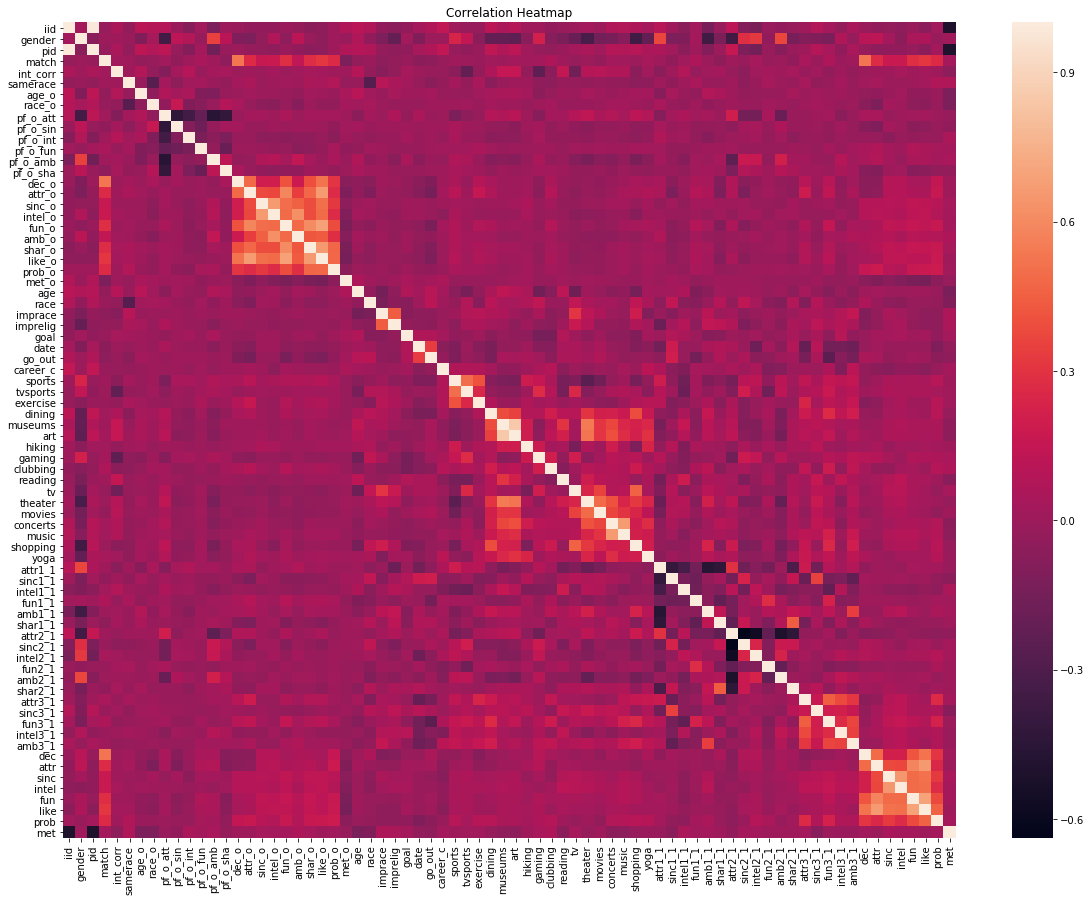

In [9]:
plt.subplots(figsize=(20,15))
ax = plt.axes()
ax.set_title("Correlation Heatmap")
corr = data.corr()
sns.heatmap(corr,xticklabels=corr.columns.values, yticklabels=corr.columns.values)

#From the heatmap, in the match column, we see there's a high positive correlation with these features -
#dec,attr,sinc.. (ratings of partner) and dec_o, attr_o.. (ratings of subject by partner)

In [10]:
data1 = data[['dec', 'dec_o', 'attr', 'attr_o', 'sinc', 'sinc_o', 'intel', 'intel_o' ,'fun', 'fun_o','amb_o', 'like', 'like_o','prob', 'prob_o', 'match']]
corr1 = data1.corr()

print(corr1)

#sns.heatmap(corr1, xticklabels = corr1.columns.values, yticklabels = corr1.columns.values)

              dec     dec_o      attr    attr_o      sinc    sinc_o     intel  \
dec      1.000000 -0.059567  0.488982 -0.066278  0.208105  0.090666  0.207812   
dec_o   -0.059567  1.000000 -0.060715  0.487445  0.094586  0.199644  0.089816   
attr     0.488982 -0.060715  1.000000 -0.045899  0.379249  0.095346  0.371460   
attr_o  -0.066278  0.487445 -0.045899  1.000000  0.097414  0.385818  0.094254   
sinc     0.208105  0.094586  0.379249  0.097414  1.000000  0.099532  0.651428   
sinc_o   0.090666  0.199644  0.095346  0.385818  0.099532  1.000000  0.087266   
intel    0.207812  0.089816  0.371460  0.094254  0.651428  0.087266  1.000000   
intel_o  0.087382  0.203672  0.098067  0.368624  0.087614  0.661394  0.071591   
fun      0.413855  0.043248  0.581734  0.061037  0.489867  0.131349  0.488909   
fun_o    0.039250  0.408875  0.065516  0.586963  0.134933  0.499286  0.120597   
amb_o    0.063585  0.174917  0.070812  0.338273  0.096754  0.453719  0.058773   
like     0.519321  0.036998 

## OLS

In [11]:
X_reg = data[['dec','dec_o','attr','attr_o','fun','fun_o','like','like_o', 'amb_o','int_corr', 'prob', 'prob_o']]
y_reg = data.match
model = sm.OLS(y_reg, X_reg)
result_reg = model.fit()
result_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  match   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     936.5
Date:                Mon, 09 Dec 2019   Prob (F-statistic):               0.00
Time:                        19:01:51   Log-Likelihood:                -145.55
No. Observations:                6041   AIC:                             315.1
Df Residuals:                    6029   BIC:                             395.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
dec            0.4463      0.008     58.397      0.000       0.431       0.461
dec_o          0.4417      0.008     57.114      0.000       0.427       0.457
attr           0.0004      0.002      0.172      0.863      -0.004       0.005
attr_o         0.0011      0.002      0.487      0.626      -0.003       0.006
fun            0.0014      0.002      0.607      0.544      -0.003       0.006
fun_o          0.0066      0.002      2.708      0.007       0.002       0.011
like          -0.0138      0.003     -4.746      0.000      -0.020      -0.008
like_o        -0.0120      0.003     -4.103      0.000      -0.018      -0.006
amb_o         -0.0123      0.002     -6.268      0.000      -0.016      -0.008
int_corr       0.0117      0.010      1.119      0.263      -0.009       0.032
prob          -0.0032      0.002     -1.815      0.070      -0.007       0.000
prob_o        -0.0016      0.002     -0.910      0.363      -0.005       0.002
==============================================================================
Omnibus:                       58.406   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              739.202
Skew:                           0.244   Prob(JB):                    3.05e-161
Kurtosis:                       1.357   Cond. No.                         61.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Classification- Kavita

gender
0    4184
1    4194
dtype: int64


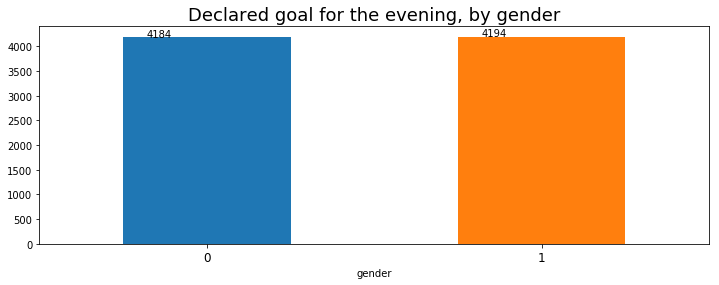

In [12]:
tmp = df[['attr', 'sinc','intel','fun','gender']].groupby(['gender']).size()
print(tmp)
ax = tmp.plot(kind='bar', figsize=(12,4))
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation='horizontal')

ax.set_title('Declared goal for the evening, by gender', fontsize=18)

for i in ax.patches:
    ax.text(i.get_x()+.07, i.get_height()+3, \
            str(round((i.get_height()), 1)), fontsize=10)

In [13]:
#columns_drop=['positin1','round','iid','idg','']

In [14]:
#data.iid[df.id==10].count()

In [15]:
n=data.isna().sum()
if n.any()>0:
    print(n)
else:
    print('No null values')

No null values


In [16]:
#for col in df.columns:
#    if df[col].isna().sum()>6000:
#        columns_drop.append(col)
#df.drop(columns_drop,axis=1)

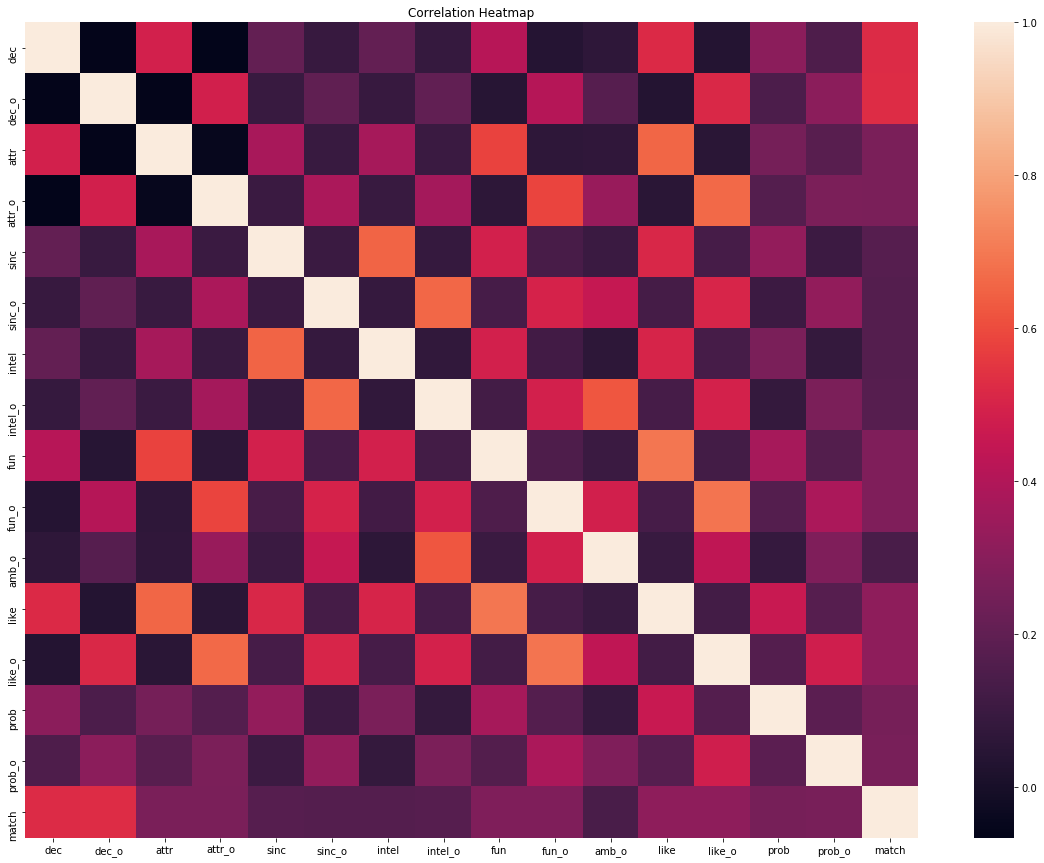

In [18]:
plt.subplots(figsize=(20,15))
ax = plt.axes()
ax.set_title("Correlation Heatmap")
corr = data1.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [60]:
attr_m=df[['iid','attr_o']].groupby(['iid']).mean()
attr_self=df[['iid','attr3_1']].groupby(['iid']).mean()
dev=attr_self['attr3_1']-attr_m['attr_o']
std_dev=dev.values.tolist()
part_dec=df[['iid','dec']].groupby(['iid']).count()
p_d=part_dec.values.tolist()

In [62]:
f=np.column_stack((p_d,dev))
d=pd.DataFrame(f,columns=['num_matches','std_dev'])


In [63]:
over_est=d[d['std_dev']>0]
ov=over_est['num_matches'].shape
print('Number of people who over-estimated their attractiveness:'+str(ov[0]))
un_est=d[d['std_dev']<0]
un=un_est['num_matches'].shape
print('Number of people who under-estimated their attractiveness:'+str(un[0]))
pr_est=d[d['std_dev']==0]
pr=pr_est['num_matches'].shape
print('Number of people who properly estimated their attractiveness:'+str(pr[0]))

Number of people who over-estimated their attractiveness:397
Number of people who under-estimated their attractiveness:137
Number of people who properly estimated their attractiveness:8


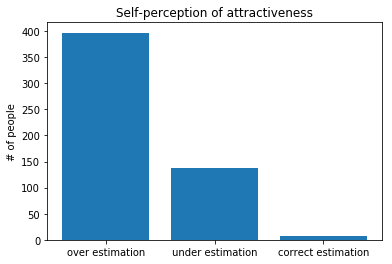

In [64]:
num=np.hstack([ov,un,pr])
fig, ax = plt.subplots()
labels=np.array(['over estimation','under estimation','correct estimation'])
ax.set_xticklabels(labels)
plt.bar(labels,num)
plt.ylabel('# of people')
plt.title('Self-perception of attractiveness')
plt.show()
# TODO plot both genders, effect on match

### ADASYN- Oversampling

#### The dataset is not balanced-

In [65]:
class_counts=df["match"].value_counts()
x=np.array(range(df.shape[0]))
print(class_counts)

0    6998
1    1380
Name: match, dtype: int64


In [11]:
def class_counts(classes):
    a = [0,0]
    for c in classes:
        a[int(c)] += 1
        count = {0 : a[0], 1: a[1]}
    return count

In [12]:
def adasamp(X,y):
    sm = ADASYN()
    y_=y
    print("Distribution of datapoints in the given dataset: ", class_counts(y_))
    X, y = sm.fit_sample(X, y)
    #print(y.shape,y_.shape)
    print("Distribution of datapoints after ADASYN Resampling: ", class_counts(y))
    return(X,y)

### SMOTE- Oversampling

In [13]:
def smote(X,y):
    sm = SMOTE()
    y_=y
    print("Distribution of datapoints in the given dataset: ", class_counts(y_))
    X, y = sm.fit_sample(X, y)
    #print(y.shape,y_.shape)
    print("Distribution of datapoints after SMOTE Resampling: ", class_counts(y))
    return(X,y)

## Classification using random forest

In [14]:
def RF(X_train,y_train,X_test,y_test):
    tr_auc=[]
    cv_auc=[]
    depth_values=[1,5,10,20,50]
    count=1
    for dep in depth_values:        
        estim=[5,10,20]
        for n in estim:
            rf_clf=RandomForestClassifier(n_estimators=n,criterion='gini', max_depth=dep,class_weight = "balanced")
            rf_clf.fit(X_train,y_train)
            y_coef=rf_clf.feature_importances_
            
            y_pred=rf_clf.predict(X_test)
            trauc=rf_clf.predict_proba(X_train)[:,1]
            cvauc=rf_clf.predict_proba(X_test)[:,1]
            
            
            tr_auc.append(roc_auc_score(y_train,trauc))
            cv_auc.append(roc_auc_score(y_test,cvauc))
            count +=1
            #print(f'{count}. depth={dep},estim={n} cv accuracy={cv_auc}')
    #print(cv_auc)
    return  tr_auc,cv_auc

In [15]:
def heatmap_plot(auc_tr,auc_cv):
    cm_pred=auc_cv
    depth_values=[1,5,10,20,50]
    estim=[5,10,20]
    cm = pd.DataFrame(auc_cv, index =depth_values, columns = estim)
    #auc_hm=cm.pivot()
    plt.figure(figsize = (5,3))
    sns.heatmap(cm, annot=True)

In [16]:
def test_RandomForest(X_train,y_train,X_test,y_test,dep,n):
    rf_clf=RandomForestClassifier(n_estimators=n,criterion='gini', max_depth=dep, class_weight = "balanced")
    rf_clf.fit(X_train,y_train)
    
    train_fpr, train_tpr, thresholds = roc_curve(y_train, rf_clf.predict_proba(X_train)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, rf_clf.predict_proba(X_test)[:,1])
    test_auc=auc(test_fpr, test_tpr)
    
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("TPR")
    plt.ylabel("FPR")
    plt.title("ERROR PLOTS for Train vs Test data")
    plt.show()
    
    cm_pred=rf_clf.predict(X_test)
    print("Train confusion matrix")
    print(confusion_matrix(y_train, rf_clf.predict(X_train)))
    print("Test confusion matrix")
    print(confusion_matrix(y_test, rf_clf.predict(X_test)))
    conf_mat = confusion_matrix(y_test,cm_pred)
    cm = pd.DataFrame(conf_mat, index = [i for i in "01"],
                  columns = [i for i in "01"])
    plt.figure(figsize = (4,4))
    sns.heatmap(cm, annot=True)
    return conf_mat,test_auc

#### Features=like,fun,int_corr

In [90]:
X=data[['like','fun','int_corr']]
y=data['match']
X,y=adasamp(X,y)
X_1, X_test_ldfi, y_1, y_test_ldfi = train_test_split(X, y, test_size=0.3, random_state=0)
# split the train data set into cross validation train and cross validation test
X_train_ldfi, X_cv_ldfi, y_train_ldfi, y_cv_ldfi = train_test_split(X_1, y_1, test_size=0.3)

Distribution of datapoints in the given dataset:  {0: 4978, 1: 1063}
Distribution of datapoints after ADASYN Resampling:  {0: 4978, 1: 4740}


In [91]:
tr_auc, cv_auc=RF(X_train_ldfi,y_train_ldfi,X_cv_ldfi,y_cv_ldfi)

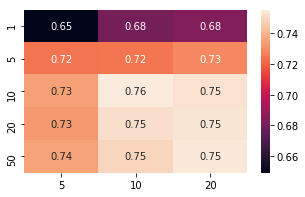

In [92]:
cv_auc=np.asarray(cv_auc)
cv_auc=cv_auc.reshape(5,3)
heatmap_plot(tr_auc, cv_auc)

In [93]:
dep=10
n=20

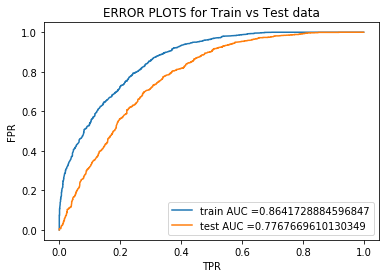

Train confusion matrix
[[1693  738]
 [ 324 2006]]
Test confusion matrix
[[ 948  553]
 [ 288 1127]]


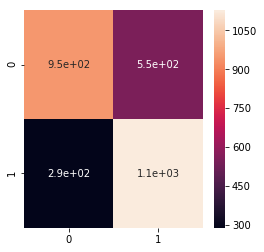

In [94]:
cf_rf,auc_rf=test_RandomForest(X_train_ldfi,y_train_ldfi,X_test_ldfi,y_test_ldfi,dep,n)

In [95]:
#Precision
pr_rf=(cf_rf[0,0]/(cf_rf[0,1]+cf_rf[0,0]))
print(pr_rf*100)

63.1578947368421


In [80]:
X=data3[['gender', 'attr_o', 'sinc_o', 'intel_o', 'shar_o', 'prob_o', 'race', 'imprace', 'goal', 'attr3_1', 'sinc3_1', 'fun3_1', 'intel3_1', 'amb3_1', 'attr', 'sinc', 'fun', 'amb', 'shar', 'prob']]
y=data3['match']
X,y=adasamp(X,y)
X_1, X_test_ldfi, y_1, y_test_ldfi = train_test_split(X, y, test_size=0.3, random_state=0)
# split the train data set into cross validation train and cross validation test
X_train_ldfi, X_cv_ldfi, y_train_ldfi, y_cv_ldfi = train_test_split(X_1, y_1, test_size=0.3)

Distribution of datapoints in the given dataset:  {0: 4580, 1: 981}
Distribution of datapoints after ADASYN Resampling:  {0: 4580, 1: 4534}


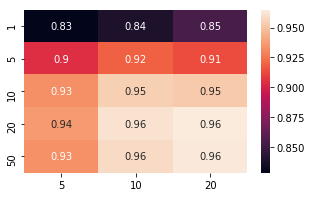

In [81]:
tr_auc_dec, cv_auc_dec=RF(X_train_ldfi,y_train_ldfi,X_cv_ldfi,y_cv_ldfi)

cv_auc_dec=np.asarray(cv_auc_dec)
cv_auc_dec=cv_auc_dec.reshape(5,3)
heatmap_plot(tr_auc_dec, cv_auc_dec)

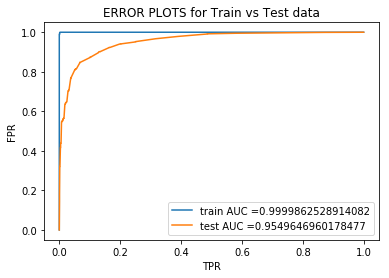

Train confusion matrix
[[2263    4]
 [   4 2194]]
Test confusion matrix
[[1223  141]
 [ 172 1199]]


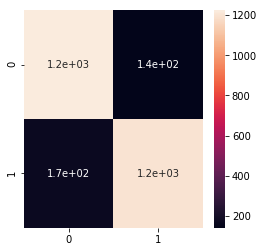

In [82]:
dep=20
n=20

cf_rf_dec,auc_rf_dec=test_RandomForest(X_train_ldfi,y_train_ldfi,X_test_ldfi,y_test_ldfi,dep,n)

In [83]:
pr_rf_dec=(cf_rf_dec[0,0]/(cf_rf_dec[0,1]+cf_rf_dec[0,0]))
print(pr_rf_dec*100)

89.66275659824046


## XGBoost

In [70]:
def xgb_train(X_train,y_train,X_test,y_test):
    tr_auc=[]
    cv_auc=[]
    depth_values=[1,5,10,20,100]
    count=1
    for dep in depth_values:        
        estim=[5, 50, 100]
        for n in estim:
            xgb_clf=xgb.XGBClassifier(max_depth=dep,n_estimators=n)
            xgb_clf.fit(X_train,y_train)
            #y_coef=rf_clf.feature_importances_
            #print(f'{count}. depth={dep},estim={n} running...')
            y_pred=xgb_clf.predict(X_test)
            trauc=xgb_clf.predict_proba(X_train)[:,1]
            cvauc=xgb_clf.predict_proba(X_test)[:,1]
            
            
            tr_auc.append(roc_auc_score(y_train,trauc))
            cv_auc.append(roc_auc_score(y_test,cvauc))
            count +=1
    #print(cv_auc)
    return  tr_auc,cv_auc

In [71]:
def test_xgb(X_train,y_train,X_test,y_test,dep,n):
    rf_clf=xgb.XGBClassifier(max_depth=dep,n_estimators=n)
    rf_clf.fit(X_train,y_train)
    
    train_fpr, train_tpr, thresholds = roc_curve(y_train, rf_clf.predict_proba(X_train)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, rf_clf.predict_proba(X_test)[:,1])
    
    test_auc=auc(test_fpr, test_tpr)
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("TPR")
    plt.ylabel("FPR")
    plt.title("ERROR PLOTS for Train vs Test data")
    plt.show()
    
    cm_pred=rf_clf.predict(X_test)
    print("Train confusion matrix")
    print(confusion_matrix(y_train, rf_clf.predict(X_train)))
    print("Test confusion matrix")
    print(confusion_matrix(y_test, rf_clf.predict(X_test)))
    conf_mat = confusion_matrix(y_test,cm_pred)
    cm = pd.DataFrame(conf_mat, index = [i for i in "01"],
                  columns = [i for i in "01"])
    plt.figure(figsize = (4,4))
    sns.heatmap(cm, annot=True)
    return conf_mat,test_auc

In [72]:
tr_auc, cv_auc=xgb_train(X_train_ldfi,y_train_ldfi,X_cv_ldfi,y_cv_ldfi)

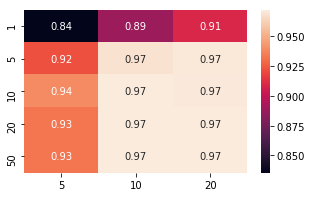

In [73]:
cv_auc=np.asarray(cv_auc)
cv_auc=cv_auc.reshape(5,3)
heatmap_plot(tr_auc, cv_auc)

In [74]:
n=5
dep=10

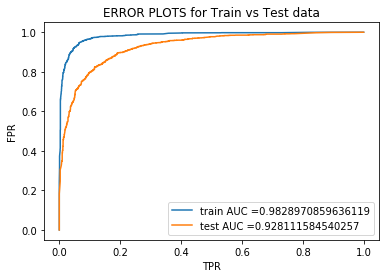

Train confusion matrix
[[2082  161]
 [ 110 2112]]
Test confusion matrix
[[1139  225]
 [ 183 1188]]


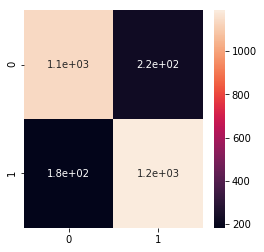

In [75]:
cf_xgb,auc_xgb=test_xgb(X_train_ldfi,y_train_ldfi,X_test_ldfi,y_test_ldfi,dep,n)

In [79]:
#Precision
pr_xgb=(cf_xgb[0,0]/(cf_xgb[0,1]+cf_xgb[0,0]))
print(pr_xgb*100)

83.50439882697948


## SVC

In [49]:
def svc_train(X_train,y_train,X_test,y_test):
    tr_auc=[]
    cv_auc=[]
    count=1
    for g in range(-2,2):
        gam=math.pow(10,g)
        for i in range(-2,2):            
            c=math.pow(10,i)
            print(f'{count}. c={c},g={gam} running...')
            rbf_clf=SVC(C=c, kernel='rbf', gamma=gam,probability=True,class_weight='balanced')
            rbf_clf.fit(X_train,y_train)
            #rbf_clf.probability=True
            y_rbf=rbf_clf.predict(X_test)
            #y_coef=rbf_clf.dual_coef_
            trauc=rbf_clf.predict_proba(X_train)[:,1]
            cvauc=rbf_clf.predict_proba(X_test)[:,1]
            #print(roc_auc_score(y_train,trauc))
            tr_auc.append(roc_auc_score(y_train,trauc))
            cv_auc.append(roc_auc_score(y_test,cvauc))
            count+=1
    #print(count)
    #print(len(tr_auc),len(cv_auc))
    return tr_auc,cv_auc

In [50]:
def plot_svc_train(title_plot,train_auc,cv_auc):
    al=range(0,16)
    plt.plot(al, train_auc, label='Train AUC')
    plt.plot(al, cv_auc, label='CV AUC')
    plt.legend()
    plt.xlabel("Alpha")
    plt.ylabel("AUC")
    plt.title(title_plot)
    plt.show()

In [51]:
def plot_heatmap1(auc_tr,auc_cv):
    cm_pred=auc_cv
    cm = pd.DataFrame(auc_cv, index = [i for i in range(-2,2)],
                  columns = [i for i in range(-2,2)])
    plt.figure(figsize = (4,4))
    sns.heatmap(cm, annot=True)

In [52]:
def test_rbf(X_train,y_train,X_test,y_test,c,gam):
    alph=math.pow(10,c)
    rbf_clf=SVC(C=c, kernel='rbf',gamma=gam,probability=True,class_weight='balanced')
    rbf_clf.fit(X_train,y_train)
    
    train_fpr, train_tpr, thresholds = roc_curve(y_train, rbf_clf.predict_proba(X_train)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, rbf_clf.predict_proba(X_test)[:,1])
    test_auc=auc(test_fpr, test_tpr)
    
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("TPR")
    plt.ylabel("FPR")
    plt.title("ERROR PLOTS for Train vs Test data")
    plt.show()
    
    cm_pred=rbf_clf.predict(X_test)
    print("Train confusion matrix")
    print(confusion_matrix(y_train, rbf_clf.predict(X_train)))
    print("Test confusion matrix")
    print(confusion_matrix(y_test, rbf_clf.predict(X_test)))
    conf_mat = confusion_matrix(y_test,cm_pred)
    cm = pd.DataFrame(conf_mat, index = [i for i in "01"],
                  columns = [i for i in "01"])
    plt.figure(figsize = (4,4))
    sns.heatmap(cm, annot=True)
    return conf_mat,test_auc

In [53]:
tr_auc, cv_auc=svc_train(X_train_ldfi,y_train_ldfi,X_cv_ldfi,y_cv_ldfi)

1. c=0.01,g=0.01 running...
2. c=0.1,g=0.01 running...
3. c=1.0,g=0.01 running...
4. c=10.0,g=0.01 running...
5. c=0.01,g=0.1 running...
6. c=0.1,g=0.1 running...
7. c=1.0,g=0.1 running...
8. c=10.0,g=0.1 running...
9. c=0.01,g=1.0 running...
10. c=0.1,g=1.0 running...
11. c=1.0,g=1.0 running...
12. c=10.0,g=1.0 running...
13. c=0.01,g=10.0 running...
14. c=0.1,g=10.0 running...
15. c=1.0,g=10.0 running...
16. c=10.0,g=10.0 running...


In [78]:
plot_name='ldfi'
cv_auc=np.asarray(cv_auc).reshape(16,1)
#print(bow_cv_auc)
#plot_svc_train(plot_name,tr_auc, cv_auc)
cv_auc=np.asarray(cv_auc)
cv_auc=cv_auc.reshape(4,4)
#print(cv_auc.shape)
plot_heatmap1(tr_auc, cv_auc)

ValueError: cannot reshape array of size 15 into shape (16,1)

In [55]:
#alpha=11
c=1
gam=0.01

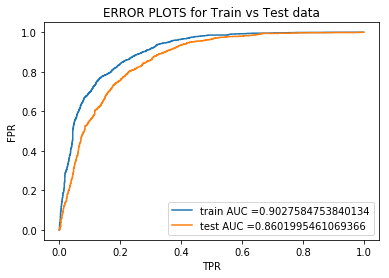

Train confusion matrix
[[1760  495]
 [ 313 1897]]
Test confusion matrix
[[ 991  373]
 [ 223 1148]]


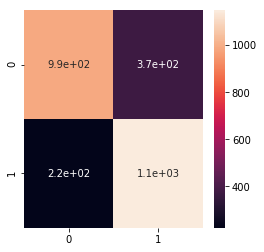

In [56]:
cf_svm,svm_auc=test_rbf(X_train_ldfi,y_train_ldfi,X_test_ldfi,y_test_ldfi,c,gam)

In [76]:
#Precision
pr=(cf_svm[0,0]/(cf_svm[0,1]+cf_svm[0,0]))
print(pr*100)

72.65395894428153


In [77]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model","AUC","Precision"]

x.add_row(["RF" , auc_rf,pr_rf])
x.add_row(["XGB" ,auc_xgb,pr_xgb])
x.add_row(["SVC", svm_auc, pr])
print(x)

NameError: name 'auc_rf' is not defined

### Creating a new .csv

In [26]:
X_train=pd.read_csv('SpeedDatingAnalysis-master\SpeedDatingAnalysis-master\data\X_train.csv')
X_train=X_train.iloc[:,0:29]
y_train = pd.read_csv('SpeedDatingAnalysis-master\SpeedDatingAnalysis-master\data\y_train.csv').values.ravel()
X_test = pd.read_csv('SpeedDatingAnalysis-master\SpeedDatingAnalysis-master\data\X_test.csv')
X_test=X_test.iloc[:,0:29]
y_test = pd.read_csv('SpeedDatingAnalysis-master\SpeedDatingAnalysis-master\data\y_test.csv').values.ravel()

#X_train,y_train=adasamp(X_train,y_train)
#X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.3)

In [131]:
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.3)

In [27]:
tr_auc, cv_auc=RF(X_train,y_train,X_cv,y_cv)

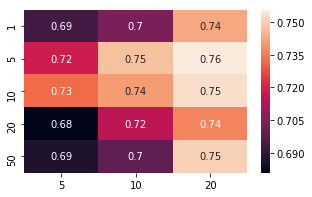

In [28]:
cv_auc=np.asarray(cv_auc)
cv_auc=cv_auc.reshape(5,3)
heatmap_plot(tr_auc, cv_auc)

In [29]:
dep=5
n=20

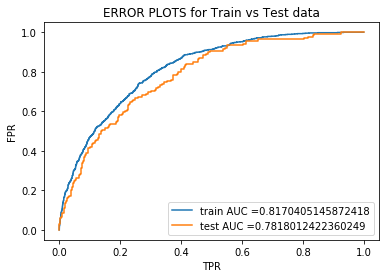

Train confusion matrix
[[3211 1213]
 [ 214  640]]
Test confusion matrix
[[517 183]
 [ 45  93]]


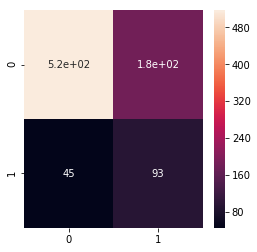

In [30]:
cf_rf_new,auc_rf_new=test_RandomForest(X_train,y_train,X_test,y_test,dep,n)

In [136]:
#Precision
#pr_new=(cf_rf_new[0,0]/(cf_rf_new[0,1]+cf_rf_new[0,0]))
#print(pr_new*100)

73.28571428571429


In [22]:
X_train=pd.read_csv('SpeedDatingAnalysis-master\SpeedDatingAnalysis-master\data\X_train.csv')
X_train=X_train.iloc[:,0:29]
y_train = pd.read_csv('SpeedDatingAnalysis-master\SpeedDatingAnalysis-master\data\y_train.csv').values.ravel()
X_test = pd.read_csv('SpeedDatingAnalysis-master\SpeedDatingAnalysis-master\data\X_test.csv')
X_test=X_test.iloc[:,0:29]
y_test = pd.read_csv('SpeedDatingAnalysis-master\SpeedDatingAnalysis-master\data\y_test.csv').values.ravel()

#X_train,y_train=adasamp(X_train,y_train)

X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.3)

### SMOTE

In [23]:
#X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.3)
X_train,y_train=smote(X_train,y_train)

Distribution of datapoints in the given dataset:  {0: 4408, 1: 870}
Distribution of datapoints after SMOTE Resampling:  {0: 4408, 1: 4408}


In [24]:
tr_auc, cv_auc=RF(X_train,y_train,X_cv,y_cv)

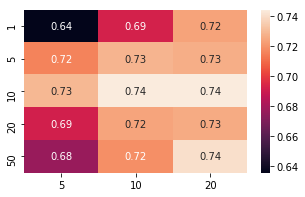

In [139]:
cv_auc=np.asarray(cv_auc)
cv_auc=cv_auc.reshape(5,3)
heatmap_plot(tr_auc, cv_auc)

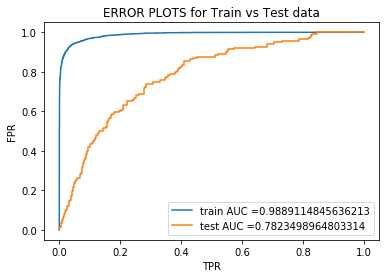

Train confusion matrix
[[4201  207]
 [ 261 4147]]
Test confusion matrix
[[642  58]
 [ 89  49]]


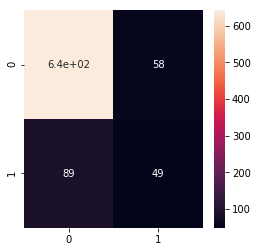

In [25]:
dep=10
n=20
cf_rf_new,auc_rf_new=test_RandomForest(X_train,y_train,X_test,y_test,dep,n)

In [142]:

#Precision
pr_new=(cf_rf_new[0,0]/(cf_rf_new[0,1]+cf_rf_new[0,0]))
print(pr_new*100)

90.57142857142857


In [60]:
X=data3[['iid','gender','age_o','int_corr','samerace','date','attr3_1','sinc3_1','fun3_1','intel3_1','amb3_1','attr','sinc','intel','fun','amb','shar','attr1_1','sinc1_1','intel1_1','fun1_1','amb1_1','shar1_1','pf_o_att','pf_o_sin','pf_o_int','pf_o_fun','pf_o_amb','pf_o_sha']]
y=data3['match']
X,y=adasamp(X,y)
X_1, X_test_ldfi, y_1, y_test_ldfi = train_test_split(X, y, test_size=0.3, random_state=0)
# split the train data set into cross validation train and cross validation test
X_train_ldfi, X_cv_ldfi, y_train_ldfi, y_cv_ldfi = train_test_split(X_1, y_1, test_size=0.3)

Distribution of datapoints in the given dataset:  {0: 4580, 1: 981}
Distribution of datapoints after ADASYN Resampling:  {0: 4580, 1: 4634}


In [64]:
tr_auc, cv_auc=xgb_train(X_train_ldfi,y_train_ldfi,X_cv_ldfi,y_cv_ldfi)

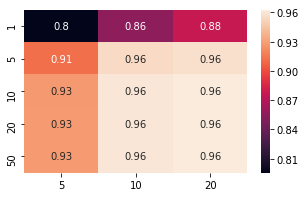

In [65]:

cv_auc=np.asarray(cv_auc)
cv_auc=cv_auc.reshape(5,3)
heatmap_plot(tr_auc, cv_auc)


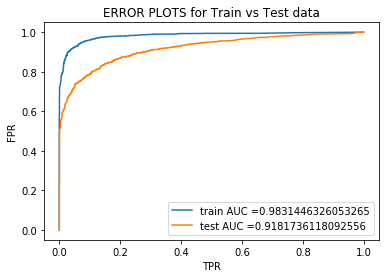

Train confusion matrix
[[2114  145]
 [ 136 2119]]
Test confusion matrix
[[1138  206]
 [ 225 1196]]


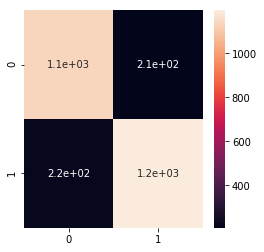

In [66]:
n=5
dep=10
cf_xgb,auc_xgb=test_xgb(X_train_ldfi,y_train_ldfi,X_test_ldfi,y_test_ldfi,dep,n)


In [149]:
#Precision
pr_xgb_smote=(cf_xgb[0,0]/(cf_xgb[0,1]+cf_xgb[0,0]))
print(pr_xgb_smote*100)

91.44345238095238


In [144]:
X=data3[['iid','gender','age_o','int_corr','samerace','date','attr3_1','sinc3_1','fun3_1','intel3_1','amb3_1','attr','sinc','intel','fun','amb','shar','attr1_1','sinc1_1','intel1_1','fun1_1','amb1_1','shar1_1','pf_o_att','pf_o_sin','pf_o_int','pf_o_fun','pf_o_amb','pf_o_sha']]
y=data3['match']
X,y=adasamp(X,y)
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
# split the train data set into cross validation train and cross validation test
X_train, X_cv, y_train, y_cv = train_test_split(X_1, y_1, test_size=0.3)

Distribution of datapoints in the given dataset:  {0: 4580, 1: 981}
Distribution of datapoints after ADASYN Resampling:  {0: 4580, 1: 4634}


In [145]:
tr_auc, cv_auc=xgb_train(X_train,y_train,X_cv,y_cv)

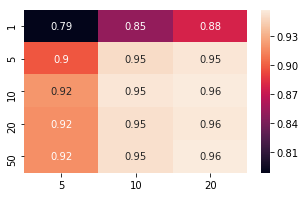

In [146]:
cv_auc=np.asarray(cv_auc)
cv_auc=cv_auc.reshape(5,3)
heatmap_plot(tr_auc, cv_auc)

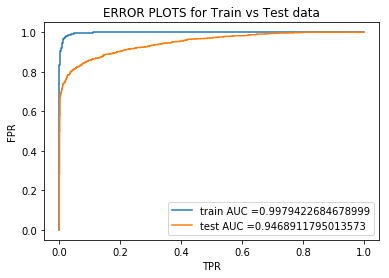

Train confusion matrix
[[2232   49]
 [  52 2181]]
Test confusion matrix
[[1229  115]
 [ 217 1204]]


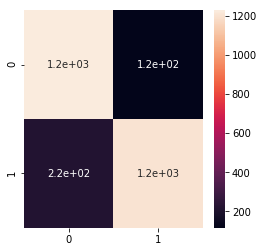

In [147]:
n=20
dep=10
cf_xgb,auc_xgb=test_xgb(X_train,y_train,X_test,y_test,dep,n)

In [150]:
#Precision
pr_xgb_new=(cf_rf_new[0,0]/(cf_rf_new[0,1]+cf_rf_new[0,0]))
print(pr_xgb_new*100)

90.57142857142857


### Recommendation

In [5]:
from scipy import spatial

In [31]:
d1=np.mean(data3[data3.iid==1])
d2=np.mean(data3[data3.iid==2])
cossim=spatial.distance.cosine(d1,d2)

In [154]:
cossim

0.13121248493586535

In [14]:
wave=data3.wave.unique()
wave
wave.shape

(21,)

In [15]:
waves={}
for i in range(wave.shape[0]):
    waves[i]=data3[data3.wave==i]

In [6]:
wave1=data3[data3.wave==1]
wave2=data3[data3.wave==2]
wave3=data3[data3.wave==3]
wave4=data3[data3.wave==4]
wave5=data3[data3.wave==5]
wave6=data3[data3.wave==6]
wave7=data3[data3.wave==7]
wave8=data3[data3.wave==8]
wave9=data3[data3.wave==9]
wave10=data3[data3.wave==10]
wave11=data3[data3.wave==11]
wave12=data3[data3.wave==12]
wave13=data3[data3.wave==13]
wave14=data3[data3.wave==14]
wave15=data3[data3.wave==15]
wave16=data3[data3.wave==16]
wave17=data3[data3.wave==17]
wave18=data3[data3.wave==18]
wave19=data3[data3.wave==19]
wave20=data3[data3.wave==20]
wave21=data3[data3.wave==20]

In [34]:
wave1.head()

,iid,gender,wave,order,partner,pid,match,int_corr,samerace,age_o,...,dec,attr,sinc,intel,fun,amb,shar,like,prob,met
0,1,0,1,4,1,11.0,0,0.14,0,27.0,...,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0,2.0
1,1,0,1,3,2,12.0,0,0.54,0,22.0,...,1,7.0,8.0,7.0,8.0,5.0,6.0,7.0,5.0,1.0
3,1,0,1,5,4,14.0,1,0.61,0,23.0,...,1,7.0,6.0,8.0,7.0,6.0,8.0,7.0,6.0,2.0
4,1,0,1,7,5,15.0,1,0.21,0,24.0,...,1,5.0,6.0,7.0,7.0,6.0,6.0,6.0,6.0,2.0
5,1,0,1,6,6,16.0,0,0.25,0,25.0,...,0,4.0,9.0,7.0,4.0,6.0,4.0,6.0,5.0,2.0


In [35]:
wave1.iid.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20], dtype=int64)

In [ ]:
wave[1]

In [43]:
sim=[]
flag=0
for k in waves:
    for l in waves:
        if k!=l:
            #print(k,l)
            for i in waves[k].iid.unique():
                for j in waves[l].iid.unique():
                    #print(i,j)

                    #print(i,j)
                    #change the below 2 lines
                    if ((data3.gender[data3.iid==i].all()==0 and data3.gender[data3.iid==j].all()==0) or (data3.gender[data3.iid==i].all()==1 and data3.gender[data3.iid==j].all()==1)):
                        per1=data3[data3.iid==i]
                        #print(per1.columns)
                        p1=per1.drop(drop_cols,axis=1)
                        per2=data3[data3.iid==j]
                        p2=per2.drop(drop_cols,axis=1)
                        d1=np.mean(p1)
                        d2=np.mean(p2)
                        #print(d1)
                        cos=spatial.distance.cosine(d1,d2)
                        #print(cos)
                        if cos>0.4:
                            flag=1
                            print('{} and {} are have similar preferences'.format(i,j,cos))
                            sim.append(list([i,j]))

                

if flag==0:
    print('No correlation')

20 and 52 are have similar preferences
20 and 66 are have similar preferences
20 and 106 are have similar preferences
20 and 108 are have similar preferences
20 and 163 are have similar preferences
20 and 168 are have similar preferences
20 and 216 are have similar preferences
20 and 222 are have similar preferences
6 and 241 are have similar preferences
8 and 241 are have similar preferences
20 and 286 are have similar preferences
20 and 315 are have similar preferences
20 and 415 are have similar preferences
52 and 20 are have similar preferences
32 and 57 are have similar preferences
32 and 79 are have similar preferences
32 and 83 are have similar preferences
32 and 90 are have similar preferences
32 and 174 are have similar preferences
32 and 252 are have similar preferences
32 and 262 are have similar preferences
52 and 373 are have similar preferences
52 and 400 are have similar preferences
66 and 20 are have similar preferences
57 and 32 are have similar preferences
57 and 241 

In [49]:
print((sim))

[[20, 52], [20, 66], [20, 106], [20, 108], [20, 163], [20, 168], [20, 216], [20, 222], [6, 241], [8, 241], [20, 286], [20, 315], [20, 415], [52, 20], [32, 57], [32, 79], [32, 83], [32, 90], [32, 174], [32, 252], [32, 262], [52, 373], [52, 400], [66, 20], [57, 32], [57, 241], [64, 241], [66, 277], [66, 373], [66, 400], [71, 492], [106, 20], [108, 20], [79, 32], [83, 32], [90, 32], [79, 241], [83, 241], [87, 241], [88, 241], [90, 241], [106, 277], [134, 241], [163, 20], [168, 20], [142, 241], [143, 241], [145, 241], [153, 241], [154, 241], [156, 241], [174, 32], [174, 241], [176, 241], [180, 241], [181, 241], [216, 20], [222, 20], [206, 241], [211, 241], [213, 241], [241, 6], [241, 8], [241, 57], [241, 64], [241, 79], [241, 83], [241, 87], [241, 88], [241, 90], [241, 134], [241, 142], [241, 143], [241, 145], [241, 153], [241, 154], [241, 156], [241, 174], [241, 176], [241, 180], [241, 181], [241, 206], [241, 211], [241, 213], [241, 252], [241, 259], [241, 262], [241, 271], [241, 295], [2

In [44]:
recomm=[]
rec={}
for p in sim:
    #print(p)
    a1=data3[data3.iid==p[0]]
    a2=data3[data3.iid==p[1]]
    #print(a1)
    for i in range(a1.shape[0]):
        ab=a1.iloc[i]
        #print(ab)
        if ab.match==1:
            p2=ab['partner']
            r=list([p[0],p2])
            rec[p[0]]=p2
            if r not in recomm:
                recomm.append(list([p[0],p2]))
                print('{} recommended to {} based on match of {}'.format(int(p2),p[0],p[1]))
    for i in range(a2.shape[0]):
        ab=a2.iloc[i]
        #print(ab)
        if ab.match==1:
            p2=ab['partner']
            r=list([p[0],p2])
            rec[p[0]]=p1
            if r not in recomm:
                recomm.append(list([p[1],p2]))
                print('{} recommended to {} based on match of {}'.format(int(p2),p[1],p[0]))


8 recommended to 20 based on match of 52
4 recommended to 108 based on match of 20
6 recommended to 108 based on match of 20
9 recommended to 108 based on match of 20
11 recommended to 108 based on match of 20
12 recommended to 163 based on match of 20
13 recommended to 163 based on match of 20
15 recommended to 163 based on match of 20
1 recommended to 168 based on match of 20
4 recommended to 6 based on match of 241
9 recommended to 6 based on match of 241
6 recommended to 241 based on match of 6
8 recommended to 241 based on match of 6
2 recommended to 8 based on match of 241
3 recommended to 8 based on match of 241
4 recommended to 8 based on match of 241
6 recommended to 8 based on match of 241
8 recommended to 8 based on match of 241
9 recommended to 8 based on match of 241
10 recommended to 8 based on match of 241
13 recommended to 315 based on match of 20
14 recommended to 315 based on match of 20
8 recommended to 20 based on match of 52
6 recommended to 57 based on match of 32

In [50]:
match_no=data3[data3.match==1]
match_num=match_no.match.count()
print('Number of matches in all the waves:{}'.format(match_num))
print('Number of additional recommendations:{}'.format(len(recomm)))

Number of matches in all the waves:981
Number of additional recommendations:235
